In [2]:
from langgraph.graph import StateGraph , START, END
from langchain_openai import ChatOpenAI
from typing import TypedDict , Annotated , Literal
from dotenv import load_dotenv 
from pydantic import BaseModel, Field
import os
import operator

In [3]:
load_dotenv()

llm = ChatOpenAI(
    model="gpt-4o-mini",                # ✅ just the plain name
    api_key=os.getenv("OPENROUTER_API_KEY"),
    base_url="https://openrouter.ai/api/v1"
)

In [4]:
class CategorySchema(BaseModel):
    category : Literal ['complaint','question','thank_you'] = Field(description="Category of the Email")

class ComplaintSchema(BaseModel):
    issue_type : Literal['shipping','billing','product','other'] = Field(description="Type of complaint")


In [5]:
Structured_llm = llm.with_structured_output(CategorySchema)

Structured_llm_2 = llm.with_structured_output(ComplaintSchema)

In [6]:
class EmailState(TypedDict):
    email : str
    category : str
    diagnose : dict
    response : str

In [7]:
def CategorizeEmail(state: EmailState) -> EmailState:
    email = state['email']
    prompt = f"""
    Categorize the following email into exactly one of these categories:

    - "complaint": if the customer is unhappy, reporting a problem, or expressing dissatisfaction.
    - "question": if the customer is asking for information but is not clearly unhappy.
    - "thank_you": if the customer is giving positive feedback, praise, or thanks.

    Email: {email}
    """
    result = Structured_llm.invoke(prompt)
    return {"category": result.category}

def check_category(state : EmailState) -> Literal['complaint_dignosis','question','thankyou']:
    if state["category"] == "thankyou":
        return "thankyou"
    elif state["category"] == "question":
        return "question"
    else:
        return 'complaint_dignosis'
    
def thankyou(state: EmailState):
    response = llm.invoke(f"Write a polite thank-you reply for this message: {state['email']}").content
    return {'response' : response}

def question(state : EmailState):
    response = llm.invoke(f"Answer this customer question clearly: {state['email']}").content
    return {'response' : response}

def complaint_dignosis(state : EmailState):
    email = state['email']
    prompt = f"""
    Classify this complaint into one of: shipping, billing, product, other.

    - "shipping": delays, missing packages, tracking problems, delivery issues.
    - "billing": wrong charges, refunds, invoices, payment issues.
    - "product": broken items, defects, wrong size, performance problems.
    - "other": anything else.

    Complaint: {email}
    """
    result = Structured_llm_2.invoke(prompt)
    return {"diagnose": result.model_dump()}

def compliant_response(state : EmailState):
    response = llm.invoke(f"Write an apology and helpful response to this {state['diagnose']['issue_type']} complaint:\n{state['email']}").content
    return {'response' : response}



In [8]:
graph = StateGraph(EmailState)

graph.add_node('CategorizeEmail' , CategorizeEmail)
graph.add_node('thankyou' , thankyou)
graph.add_node('question' , question)
graph.add_node('complaint_dignosis' , complaint_dignosis)
graph.add_node('compliant_response',compliant_response)

graph.add_edge(START , 'CategorizeEmail')
graph.add_conditional_edges('CategorizeEmail' , check_category)
graph.add_edge('thankyou' , END)
graph.add_edge('question' , END)
graph.add_edge('complaint_dignosis' , 'compliant_response')
graph.add_edge('compliant_response' , END)

workflow = graph.compile()




In [9]:
initial_state = {
    "email": "Thank you for the quick delivery! I really appreciate your service."
}


workflow.invoke(initial_state)

{'email': 'Thank you for the quick delivery! I really appreciate your service.',
 'category': 'thank_you',
 'diagnose': {'issue_type': 'other'},
 'response': "Subject: Thank You for Your Feedback!\n\nDear [Customer's Name],\n\nThank you for your kind words! We truly appreciate your positive feedback regarding our delivery service. It's wonderful to hear that you received your order quickly.\n\nIf there’s anything else we can assist you with or if you have any further concerns, please don't hesitate to reach out. We're here to help and ensure your experience with us is always a great one.\n\nThank you once again for choosing us!\n\nBest regards,  \n[Your Name]  \n[Your Position]  \n[Your Company]  \n[Contact Information]  "}

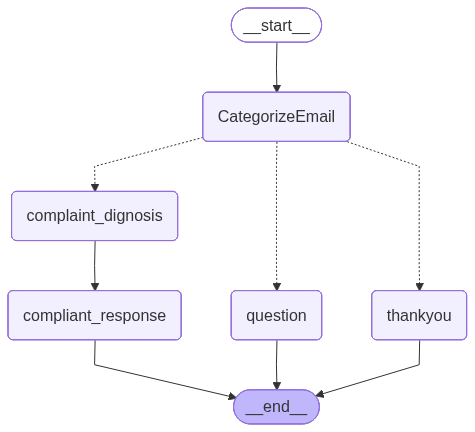

In [10]:
workflow